In [1]:
# Gerekli kütüphaneleri yükleyin
import os
import shutil
import glob
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import tensorflow as tf
from tensorflow import keras

# Uyarıları gizle
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Keras ve TensorFlow modülleri
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNet, InceptionV3, DenseNet121
from keras.applications.inception_v3 import preprocess_input
# Gerekli kütüphaneleri yükleyin

from keras.metrics import categorical_accuracy


In [2]:
# Eğitim ve Doğrulama Görüntüleri için Yollar
train_path ='C:/Users/esraa/Desktop/base_dir/train_dir'
valid_path ='C:/Users/esraa/Desktop/base_dir/val_dir'

In [3]:
#dosya listelenmesi
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [4]:
#Görüntü İşleme Fonksiyonu
def image_to_feature_vector(image, size=(224, 224)):
    return cv2.resize(image, size).flatten()

In [5]:
# ### GPU'nun uygunluğunu kontrol etme
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [6]:
def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

In [7]:
# Girdi görüntüsünün yükseklik, genişlik ve renk ayarı.
IMG_CHANNELS = 3
IMG_ROWS = 224
IMG_COLS = 224
input_shape = (IMG_ROWS, IMG_COLS ,3)

train_samples_num = get_files(train_path)
val_samples_num   = get_files(valid_path)
#test_samples_num =  len(glob.glob(test_path+"/*"))

# Birkaç yararlı değeri bildirme
epochs = 30
num_train_samples = train_samples_num
num_val_samples = val_samples_num
train_batch_size = 64
val_batch_size = 64
image_size = 224

# Bir iterasyonda kaç adım gerektiğini bildirme
train_steps = train_samples_num // train_batch_size
val_steps = val_samples_num // val_batch_size


In [8]:

# Bir ön-eğitimli imagenet modeli oluşturma
#mobile = keras.applications.mobilenet.MobileNet()

mobile = InceptionV3(input_shape=input_shape,weights='imagenet',include_top=False) 

mobile.trainable = False
# imports the model and discards the last layer.
# Modeli düzenleme
x = mobile.output
x = GlobalAveragePooling2D()(x)
# Tahminler için dropout ve dense layer ekleme
x = Dropout(0.4)(x)
#layer to convert the features to a single element vector per image.
# let's add a fully-connected layer
x = Dense(1024,activation='relu')(x) 

#we add dense layers so that the model can learn more complex 
#functions and classify for better results.
x = Dense(512,activation='relu')(x) #dense layer 2
x = Dense(512,activation='relu')(x) #dense layer 3
# and a logistic layer -- let's say we have 7 classes
predictions = Dense(7, activation='softmax')(x)
#final layer with softmax activation for 7 classes

# Yeni çıktılı bir model oluşturma
model = Model(inputs=mobile.input, outputs=predictions)

In [9]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

# Eğitilmeyen katmanların ağırlıklarını dondurma 
for layer in model.layers[:-6]:
   layer.trainable = False
for layer in model.layers[159:]:
   layer.trainable = True
   
# Modeldeki yeni katmanların özetine bakma
model.summary()

0 input_layer
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 24,692,007 (94.19 MB)

 Trainable params: 19,530,631 (74.50 MB)

 Non-trainable params: 5,161,376 (19.69 MB)

In [10]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Üreticileri ayarlama
train_batches = data_gen.flow_from_directory(train_path,
                                             target_size=(image_size,image_size),
                                             batch_size=train_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

valid_batches = data_gen.flow_from_directory(valid_path,
                                             target_size=(image_size,image_size),
                                             batch_size=val_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

test_batches = data_gen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,
                                            shuffle=False,
                                            color_mode='rgb',
                                            class_mode='categorical'
                                            )

Found 36529 images belonging to 7 classes.
Found 3673 images belonging to 7 classes.
Found 3673 images belonging to 7 classes.


In [11]:
# Modeli derleme (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['categorical_accuracy'])


# Save edilmiş model için dosya yolunu bildirme
filepath = "C:/Users/esraa/Desktop/base_dir/inception_model.keras"

# Modelin en iyi versiyonunu save etmek için bir checkpoint bildirme
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='min')

# Öğrenme durgunlaştıkça öğrenme oranını azaltma
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.5, 
                              patience=2,
                              verbose=1, 
                              mode='min', 
                              min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

In [12]:
# Modeli eğitme
history = model.fit(
    train_batches,
    steps_per_epoch=train_steps,
    validation_data=valid_batches,
    validation_steps=val_steps,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/30
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2788 - loss: 2.4226
Epoch 1: loss improved from inf to 1.54967, saving model to C:/Users/esraa/Desktop/base_dir/inception_model.keras
570/570 ━━━━━━━━━━━━━━━━━━━━ 2001s 3s/step - categorical_accuracy: 0.2790 - loss: 2.4211 - val_categorical_accuracy: 0.4901 - val_loss: 1.4769 - learning_rate: 0.0100
Epoch 2/30
  1/570 ━━━━━━━━━━━━━━━━━━━━ 31:50 3s/step - categorical_accuracy: 0.6562 - loss: 1.0011
Epoch 2: loss improved from 1.54967 to 1.00106, saving model to C:/Users/esraa/Desktop/base_dir/inception_model.keras
570/570 ━━━━━━━━━━━━━━━━━━━━ 103s 176ms/step - categorical_accuracy: 0.6562 - loss: 1.0011 - val_categorical_accuracy: 0.4940 - val_loss: 1.4987 - learning_rate: 0.0100
Epoch 3/30
570/570 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6882 - loss: 0.7998
Epoch 3: loss improved from 1.00106 to 0.71494, saving model to C:/Users/esraa/Desktop/base_dir/inception_model.keras
570/570 ━━━━━━━━━━━━

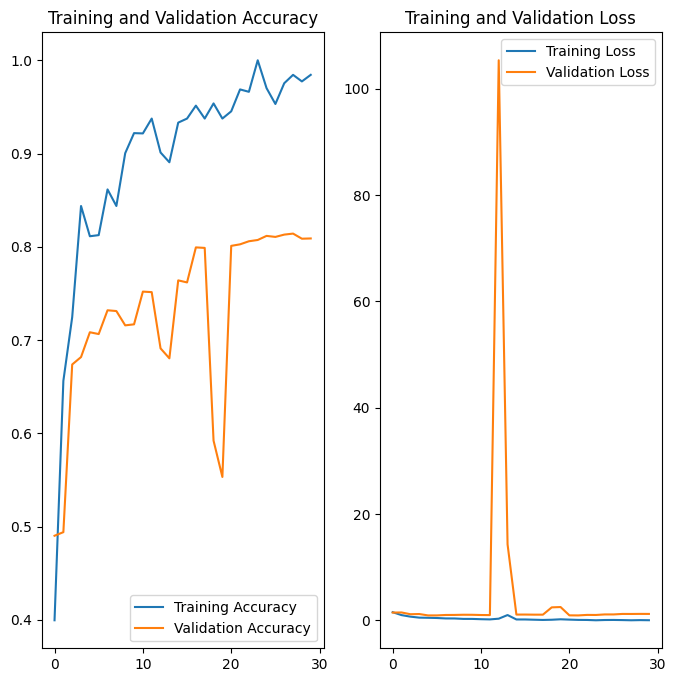

In [13]:
# Eğitim sonuçlarını görselleştirme
acc = history.history.get('categorical_accuracy', [])
val_acc = history.history.get('val_categorical_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Modelin tahminlerini al
test_labels = test_batches.classes
predictions = model.predict(test_batches, verbose=1)
predicted_classes = predictions.argmax(axis=1)

# Hassasiyet, geri çağırma, F1 skor hesaplama
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


58/58 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step
Precision: 0.8192553820360098
Recall: 0.8088755785461476
F1 Score: 0.8090199578982309


In [15]:
# En iyi dönüm için hesaplama

val_loss, val_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_acc)

model.load_weights(filepath)


57/57 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - categorical_accuracy: 0.7366 - loss: 1.7137
val_loss: 1.2206624746322632
val_cat_acc: 0.8097587823867798


58/58 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step
Normalized Confusion Matrix
[[0.62650602 0.06626506 0.22088353 0.03012048 0.05220884 0.00401606
  0.        ]
 [0.0259481  0.88822355 0.03592814 0.         0.02994012 0.01996008
  0.        ]
 [0.02       0.016      0.726      0.016      0.162      0.06
  0.        ]
 [0.08506224 0.06016598 0.02489627 0.80912863 0.00829876 0.01244813
  0.        ]
 [0.01996008 0.00998004 0.15768463 0.00598802 0.71457086 0.08183633
  0.00998004]
 [0.00447094 0.00447094 0.02086438 0.         0.03874814 0.9314456
  0.        ]
 [0.         0.00961538 0.00769231 0.06538462 0.00192308 0.01153846
  0.90384615]]


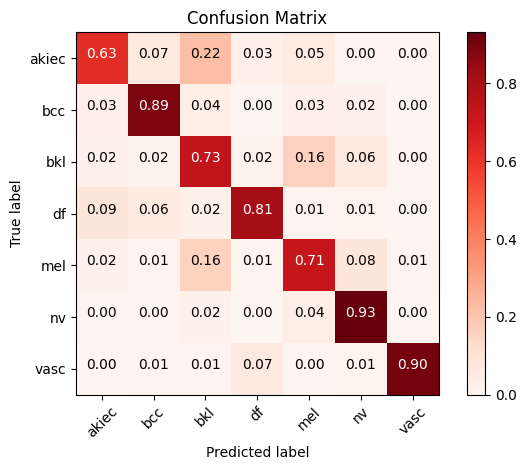

In [16]:
# Test görüntülerinin confusion matrisini oluşturma
test_labels = test_batches.classes

# Tahmin yapma
predictions = model.predict(test_batches, test_batches.n//test_batches.batch_size+1, verbose=1)
predictions = np.argmax(predictions, axis=1)

# Confusion matrisi fonksiyonu
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Reds):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(cm, cm_plot_labels)


image shape: (224, 224, 3)


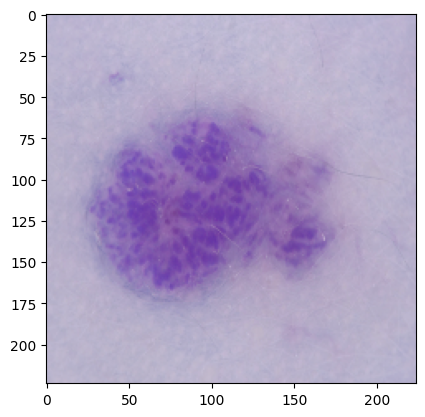

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[1.4260423e-06 1.7965995e-07 2.7271146e-03 2.2810649e-07 6.3929992e-04
  9.9663144e-01 2.6695727e-07]]
nv


In [17]:

img_test = cv2.imread(valid_path+'/vasc/ISIC_0026876.jpg')
# Resizing image
img_scaled = cv2.resize(img_test,(image_size,image_size))
img_test = tf.image.convert_image_dtype(img_scaled, dtype=tf.float32,
                                        saturate=False)
print("image shape: {}".format(img_test.shape))
plt.imshow(img_test)
plt.show()
#img_test = img_test/255.

img_test = np.expand_dims(img_test, axis=0)
# getting model predictions
test_predictions = model.predict(img_test)
print(test_predictions)
predicted_label = np.argmax(test_predictions)

print(cm_plot_labels[predicted_label])

In [18]:
# .keras modelini yükleme
model = tf.keras.models.load_model("C:/Users/esraa/Desktop/base_dir/inception_model.keras")

# Modeli .h5 formatında kaydetme
model.save("C:/Users/esraa/Desktop/base_dir/inception_model.h5")
